<a href="https://colab.research.google.com/github/magicaltrap/breastcancer_detection/blob/master/breastcancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup#

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [5]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
path_breastcancer = "/content/gdrive/My Drive/data/breastcancer/"
path_breastcancer_data = "/content/gdrive/My Drive/data/breastcancer/data/"

Mounted at /content/gdrive


In [0]:
from fastai import *
from fastai.vision import *

# Prepare Dataset

In [0]:
bs = 64

In [0]:
data = (ImageList.from_folder(path=path_breastcancer + "data_40x") #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct(valid_pct=0.3)  #train=70%, valid=30% of data            
        .label_from_folder()    #label according to the folder names (benign, malignant)        
        .transform(tfms=get_transforms(do_flip=True, flip_vert=True), size=224) #apply image augmentation
        .databunch()
        .normalize()) #mean=0 , standard diviation=1

In [13]:
print(data.classes)

['benign', 'malignant']


In [14]:
len(data.train_ds), len(data.valid_ds)

(1397, 598)

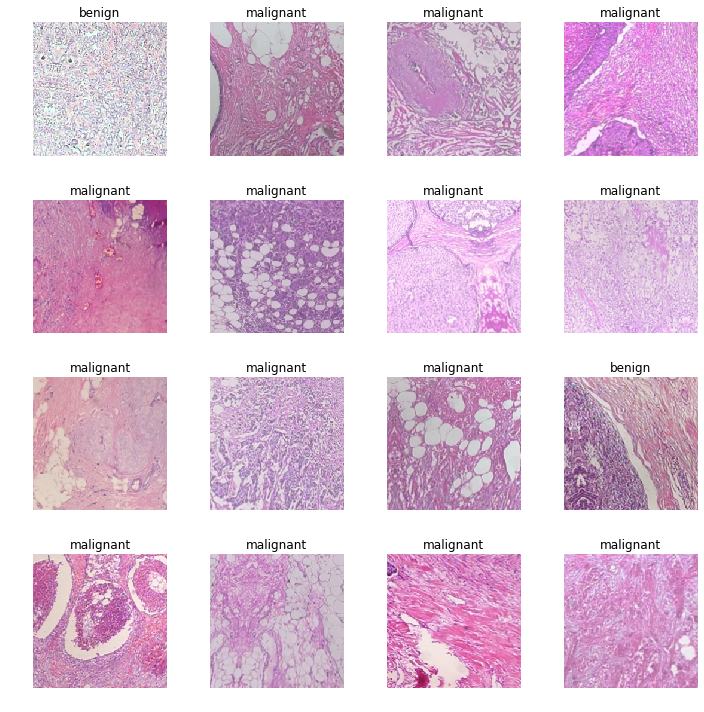

In [17]:
data.show_batch(rows=4, figsize=(10,10))

In [15]:
data

ImageDataBunch;

Train: LabelList (1397 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
benign,benign,benign,benign,benign
Path: /content/gdrive/My Drive/data/breastcancer/data_40x;

Valid: LabelList (598 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
malignant,benign,malignant,malignant,malignant
Path: /content/gdrive/My Drive/data/breastcancer/data_40x;

Test: None

# Load pre-trained resnet50 CNN model # 

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


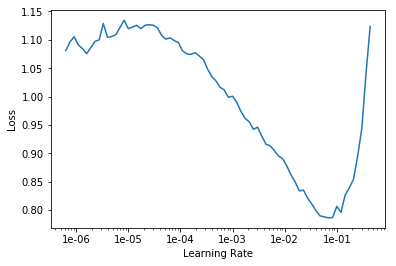

In [20]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

# Training

In [25]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.897385,0.445857,0.839465,01:18
1,0.638742,0.263104,0.913043,01:18
2,0.485731,0.195372,0.928094,01:18


We already achieve an accuracy of 92.8% after four minutes of training!

In [0]:
learn.save("clas1")

In [27]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

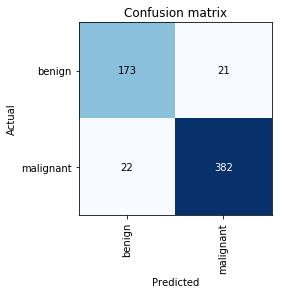

In [31]:
interp.plot_confusion_matrix()

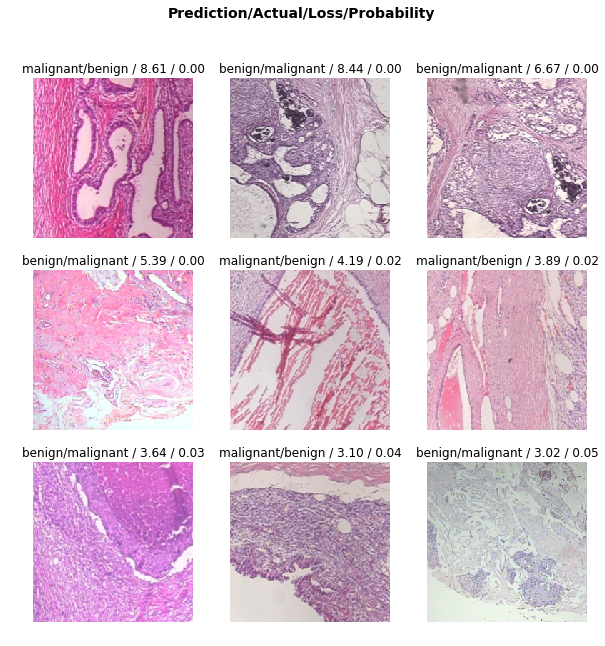

In [32]:
interp.plot_top_losses(9, figsize=(10,10))

In [0]:
learn.load("clas1")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


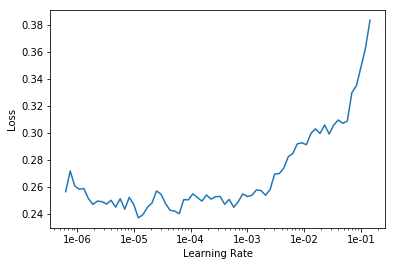

In [34]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.unfreeze()

In [37]:
learn.fit_one_cycle(3, 1e-6)

epoch,train_loss,valid_loss,accuracy,time
0,0.268547,0.206116,0.928094,01:21
1,0.270120,0.205103,0.928094,01:20
2,0.251978,0.201367,0.933110,01:21


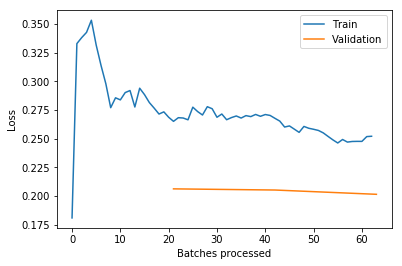

In [39]:
learn.recorder.plot_losses()

# Interpretation # 

In [40]:
preds,y, loss = learn.get_preds(with_loss=True)
acc = accuracy(preds, y)
print(f'The accuracy is {acc*100}%.')

The accuracy is 93.31103515625%.


In [41]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

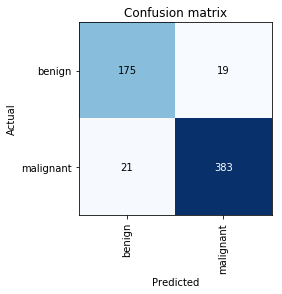

In [42]:
interp.plot_confusion_matrix()

## Precision, Recall, F1 ##

In [0]:
TP = 383 #predicted malignant and actual malignant (breast cancer is correctly detected)
TN = 175
FP = 19
FN = 21

In [44]:
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1 = 2*((precision*recall)/(precision+recall))

precision, recall, F1

(0.9527363184079602, 0.948019801980198, 0.9503722084367247)

# Example Prediction

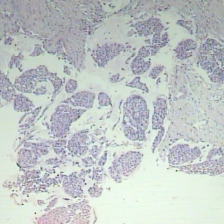

In [49]:
img = learn.data.valid_ds[0][0]
img

In [50]:
learn.predict(img)

(Category benign, tensor(0), tensor([0.7740, 0.2260]))